In [1]:
import imp
import matplotlib.pyplot as plt
import numpy as np
import os
#pillow
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib

In [2]:
#give the url 
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
#decompress, retieve flower photos and then untar it
data_dir = tf.keras.utils.get_file('flower_photos',origin=dataset_url,untar=True)
data_dir=pathlib.Path(data_dir)

228827136/228813984 [==============================] - 2s 0us/step


In [3]:
#all the files have .jpg extention
image_count=len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


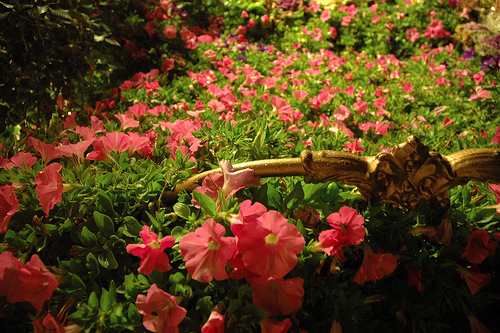

In [5]:
roses=list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

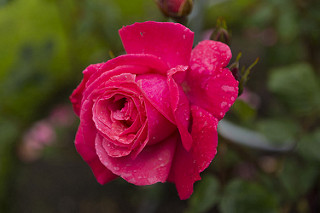

In [6]:
PIL.Image.open(str(roses[1]))

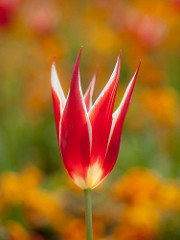

In [7]:
tulips=list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

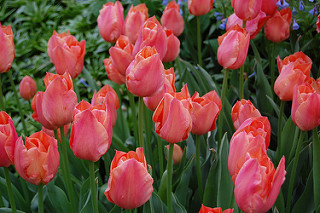

In [8]:
PIL.Image.open(str(tulips[1]))

In [12]:
batch_size=32
imgheight=180
imgwidth=180

In [13]:
trainds=tf.keras.preprocessing.image_dataset_from_directory(data_dir,validation_split=0.2,subset='training',seed=123,
image_size=(imgheight,imgwidth),batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [14]:
testds=tf.keras.preprocessing.image_dataset_from_directory(data_dir,validation_split=0.2,subset='validation',seed=123,
image_size=(imgheight,imgwidth),batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [15]:
classnames=trainds.class_names
classnames

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

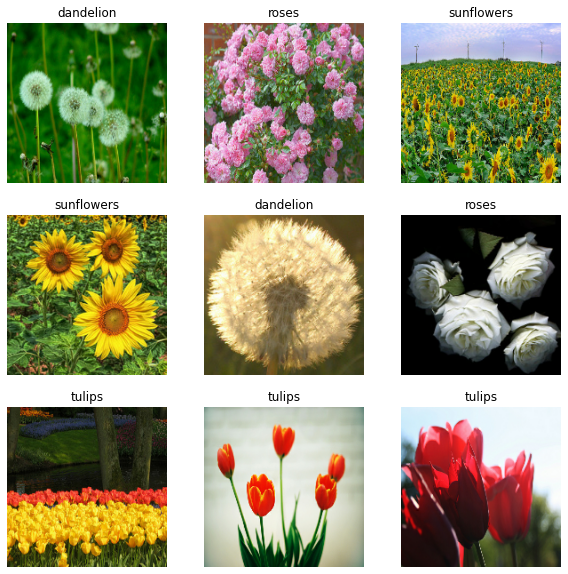

In [19]:
plt.figure(figsize=(10,10))
for images,labels in trainds.take(1):
  #9 images
  for i in range(9):
    #make 3 rows and 3 columns
    ax=plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(classnames[labels[i]])
    plt.axis('off')

In [21]:
#print shape of images
for image_batch,labels_batch in trainds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break
  #rgb value is 3 means colored image
  #for 32 images , 32 labels


(32, 180, 180, 3)
(32,)


In [25]:
#autotune makes the program run fast
#to make it happen, put images in cache memory
#whatever is put in the cache memory it runs fast
#autotune is used to pick the automatically picked images
autotune=tf.data.AUTOTUNE
trainds=trainds.cache().shuffle(1000).prefetch(buffer_size=autotune)
testds = testds.cache().prefetch(buffer_size=autotune)

In [26]:
#we try to normalise the colored image so that it doesnt consume much resources
normalizationlayer=layers.experimental.preprocessing.Rescaling(1./255)

In [28]:
#learning the features
num_class=5
model=Sequential([layers.experimental.preprocessing.Rescaling(1./255,input_shape=(imgheight,imgwidth,3)),
layers.Conv2D(16,3,padding="same",activation='relu'),layers.MaxPooling2D(),
layers.Conv2D(32,3,padding="same",activation='relu'),layers.MaxPooling2D(),
layers.Conv2D(64,3,padding="same",activation='relu'),layers.MaxPooling2D(),
#fallern is used to make matrix in layers
layers.Flatten(),
#implementing the learned
layers.Dense(128,activation='relu'),layers.Dense(num_class)])

In [30]:
model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

In [31]:
#any deeplearning task related to images use the least number of epochs
#trained the model with bacth of 32 size
#every epoch 92 batches was created
epochs=4
history=model.fit(trainds,validation_data=testds,epochs=epochs)
#the loss value is decreasing gradually

Epoch 1/4
92/92 [==============================] - 92s 941ms/step - loss: 1.4485 - val_loss: 1.1738
Epoch 2/4
92/92 [==============================] - 85s 929ms/step - loss: 1.0498 - val_loss: 1.0562
Epoch 3/4
92/92 [==============================] - 85s 930ms/step - loss: 0.8762 - val_loss: 0.9890
Epoch 4/4
92/92 [==============================] - 86s 933ms/step - loss: 0.6382 - val_loss: 0.9922


In [32]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

131072/117948 [=================================] - 0s 0us/step


In [33]:
#load image ,convert to array and make batches
img = keras.preprocessing.image.load_img(sunflower_path,target_size=(imgheight,imgwidth))
imgarray=keras.preprocessing.image.img_to_array(img)
imgarray=tf.expand_dims(imgarray,0)

In [35]:
#passed the batch to the predict function
#softmax gives us the score
pred=model.predict(imgarray)
score=tf.nn.softmax(pred[0])
print(
    "This image most likely belongs to  {} with a {:.2f} percent confidence."
    .format(classnames[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to  sunflowers with a 77.42 percent confidence.
